In [1]:
from typing import TypedDict, Annotated
import operator

from langgraph.graph import StateGraph, END

from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv
load_dotenv()

/Users/rachneet/projects/agents_experimental/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [49]:
llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen3-Next-80B-A3B-Instruct",
    max_new_tokens=1024,
    temperature=0,
    provider="together"
)

chat_model = ChatHuggingFace(llm=llm)

In [100]:
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver

# memory = SqliteSaver.from_conn_string(":memory:")
conn = sqlite3.connect("agent_memory.db", check_same_thread=False)
memory = SqliteSaver(conn)

In [66]:
from uuid import uuid4
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage

"""
In previous examples we've annotated the `messages` state key
with the default `operator.add` or `+` reducer, which always
appends new messages to the end of the existing messages array.

Now, to support replacing existing messages, we annotate the
`messages` key with a customer reducer function, which replaces
messages with the same `id`, and appends them otherwise.
"""
def reduce_messages(left: list[AnyMessage], right: list[AnyMessage]) -> list[AnyMessage]:
    # assign ids to messages that don't have them
    for message in right:
        if not message.id:
            message.id = str(uuid4())
    # merge the new messages with the existing messages
    merged = left.copy()
    for message in right:
        for i, existing in enumerate(merged):
            # replace any existing messages with the same id
            if existing.id == message.id:
                merged[i] = message
                break
        else:
            # append any new messages to the end
            merged.append(message)
    return merged

class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], reduce_messages]

In [67]:
tool = TavilySearchResults(max_results=2)

In [68]:
class Agent:

    def __init__(self, model, tools, checkpointer, system=""):

        self.system = system
        graph = StateGraph(AgentState)

        graph.add_node("llm", self.call_model)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {
                True: "action", False: END
            }
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")

        self.graph = graph.compile(
            checkpointer=checkpointer,
            interrupt_before=["action"]  # interrupt before tool call
        )
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def call_model(self, state: AgentState):
        messages = state["messages"]
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {"messages": [message]}

    def take_action(self, state: AgentState):
        tool_calls = state["messages"][-1].tool_calls
        results = []

        for t in tool_calls:
            print(f"Calling: '{t}' ")
            result = self.tools[t["name"]].invoke(t["args"])
            results.append(ToolMessage(
                tool_call_id=t["id"], 
                name=t["name"], 
                content=str(result)
            ))
        
        return {"messages": results}

    def exists_action(self, state: AgentState):
        result = state["messages"][-1]
        return len(result.tool_calls) > 0

In [69]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

In [70]:
abot = Agent(chat_model, [tool], checkpointer=memory, system=prompt)

In [71]:
messages = [HumanMessage(content="What is the weather in berlin?")]
thread = {
    "configurable": {"thread_id": "1"}
}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Berlin"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 252, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e06350f9-b6bb-49ae-81ec-802518c0aa3b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Berlin'}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 252, 'output_tokens': 27, 'total_tokens': 279})]}
()


In [72]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in berlin?', additional_kwargs={}, response_metadata={}, id='881e7262-03df-49ae-a3d8-e37a49a45e6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Berlin"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 252, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e06350f9-b6bb-49ae-81ec-802518c0aa3b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Berlin'}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 252, 'output_tokens': 27, 'total_tokens': 279})]}, next=('action',), config={'configurable': {'threa

In [73]:
abot.graph.get_state(thread).next

('action',)

### continue after interrupt

In [74]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Berlin'}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'tool_call'}' 
{'messages': [ToolMessage(content="[{'title': 'Berlin weather in October 2025 - Weather25.com', 'url': 'https://www.weather25.com/europe/germany/berlin?page=month&month=October', 'content': 'weather25.com\\nSearch\\nweather in Germany\\nRemove from your favorite locations\\nAdd to my locations\\nShare\\nweather in Germany\\n\\n# Berlin weather in October 2025\\n\\nLight rain shower\\nLight drizzle\\nLight drizzle\\nPatchy rain possible\\nPatchy rain possible\\nModerate rain\\nModerate rain\\nClear\\nCloudy\\nLight drizzle\\nMist\\nPartly cloudy\\nPatchy rain possible\\nPartly cloudy\\n\\n## The average weather in Berlin in October [...] | 26 Patchy rain possible 10° /7° | 27 Moderate rain 9° /7° | 28 Moderate rain 10° /8° | 29 Sunny 12° /7° | 30 Cloudy 12° /6° | 31 Light drizzle 13° /10° |  | [...] | Sun | Mon | Tue | Wed | Thu |

In [75]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='What is the weather in berlin?', additional_kwargs={}, response_metadata={}, id='881e7262-03df-49ae-a3d8-e37a49a45e6d'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Berlin"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 252, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e06350f9-b6bb-49ae-81ec-802518c0aa3b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Berlin'}, 'id': 'call_c5a7e9259d6f4d6182b0603b', 'type': 'tool_call'}], usage_metadata={'input_tokens': 252, 'output_tokens': 27, 'total_tokens': 279}), ToolMessage(content="[{'title': 'Berlin weather in 

In [76]:
abot.graph.get_state(thread).next

()

In [77]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "3"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)
while abot.graph.get_state(thread).next:
    print("\n", abot.graph.get_state(thread),"\n")
    _input = input("proceed?")
    if _input != "y":
        print("aborting")
        break
    for event in abot.graph.stream(None, thread):
        for v in event.values():
            print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_20923e42804e406c9a987cb4', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--abf337e6-79aa-4ae2-8ec8-074dd49acefe-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_20923e42804e406c9a987cb4', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})]}
()

 StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='bf1a9a9b-3b88-4677-a1d3-9bc48368d885'), AIMessage(content='', addit

## Modify the state

In [78]:
messages = [HumanMessage("Whats the weather in LA?")]
thread = {"configurable": {"thread_id": "6"}}
for event in abot.graph.stream({"messages": messages}, thread):
    for v in event.values():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--555c4ba8-462a-466a-93db-d29467cb4cd2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})]}
()


In [79]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='8f480365-4bfe-477b-b560-4c0801a5134a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--555c4ba8-462a-466a-93db-d29467cb4cd2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})]}, next=('action',), config={'configurable': {'t

In [80]:
current_values = abot.graph.get_state(thread)

In [81]:
current_values.values['messages'][-1]

AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--555c4ba8-462a-466a-93db-d29467cb4cd2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})

In [82]:
current_values.values['messages'][-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Los Angeles'},
  'id': 'call_86ca497f53b64c7a9f5e61d1',
  'type': 'tool_call'}]

In [83]:
_id = current_values.values['messages'][-1].tool_calls[0]['id']
current_values.values['messages'][-1].tool_calls = [
    {'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in Louisiana'},
  'id': _id}
]

In [84]:
abot.graph.update_state(thread, current_values.values)

{'configurable': {'thread_id': '6',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0af56b-e6f1-60ba-8002-4e42fc61dc09'}}

In [85]:
abot.graph.get_state(thread)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='8f480365-4bfe-477b-b560-4c0801a5134a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--555c4ba8-462a-466a-93db-d29467cb4cd2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})]}, next=('action',), config={'configurable': {'thr

In [86]:
for event in abot.graph.stream(None, thread):
    for v in event.values():
        print(v)

Calling: '{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}' 
{'messages': [ToolMessage(content="[{'title': 'Louisiana weather in October 2025 - Weather25.com', 'url': 'https://www.weather25.com/north-america/usa/louisiana?page=month&month=October', 'content': 'weather25.com\\nSearch\\nweather in United States\\nRemove from your favorite locations\\nAdd to my locations\\nShare\\nweather in United States\\n\\n# Louisiana weather in October 2025\\n\\nOvercast\\nOvercast\\nOvercast\\nPatchy rain possible\\nHeavy rain\\nPatchy light drizzle\\nLight rain shower\\nPatchy rain possible\\nClear\\nClear\\nClear\\nClear\\nPatchy rain possible\\nClear\\n\\n## The average weather in Louisiana in October\\n\\nThe weather in Louisiana in October is hot. The average temperatures are between 20°C and 27°C. [...] | 26 Heavy rain 24° /22° | 27 Patchy light drizzle 28° /21° | 28 Light rain shower 27° /21° 

## Time Travel

In [87]:
states = []
for state in abot.graph.get_state_history(thread):
    print(state)
    print('--')
    states.append(state)

StateSnapshot(values={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='8f480365-4bfe-477b-b560-4c0801a5134a'), AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--555c4ba8-462a-466a-93db-d29467cb4cd2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Louisiana'}, 'id': 'call_86ca497f53b64c7a9f5e61d1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279}), ToolMessage(content="[{'title': 'Louisiana weathe

In [88]:
to_replay = states[-1]

In [89]:
to_replay

StateSnapshot(values={'messages': []}, next=('__start__',), config={'configurable': {'thread_id': '6', 'checkpoint_ns': '', 'checkpoint_id': '1f0af56b-0c43-65ee-bfff-7eb2d3fc572f'}}, metadata={'source': 'input', 'step': -1, 'parents': {}}, created_at='2025-10-22T14:52:11.618247+00:00', parent_config=None, tasks=(PregelTask(id='de9bf92b-e924-3411-cc30-08c155158290', name='__start__', path=('__pregel_pull', '__start__'), error=None, interrupts=(), state=None, result={'messages': [HumanMessage(content='Whats the weather in LA?', additional_kwargs={}, response_metadata={}, id='8f480365-4bfe-477b-b560-4c0801a5134a')]}),), interrupts=())

In [90]:
for event in abot.graph.stream(None, to_replay.config):
    for k, v in event.items():
        print(v)

{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'function': {'arguments': '{"query": "current weather in Los Angeles"}', 'name': 'tavily_search_results_json', 'description': None}, 'id': 'call_7f86a2cc4a19433ca412b73f', 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 28, 'prompt_tokens': 251, 'total_tokens': 279}, 'model_name': 'Qwen/Qwen3-Next-80B-A3B-Instruct', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--d8eb5455-e975-4cc6-acb0-62ecef121888-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_7f86a2cc4a19433ca412b73f', 'type': 'tool_call'}], usage_metadata={'input_tokens': 251, 'output_tokens': 28, 'total_tokens': 279})]}
()


In [91]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']
to_replay.values['messages'][-1].tool_calls = [{'name': 'tavily_search_results_json',
  'args': {'query': 'current weather in LA, accuweather'},
  'id': _id}]

IndexError: list index out of range

In [ ]:
branch_state = abot.graph.update_state(to_replay.config, to_replay.values)

In [ ]:
for event in abot.graph.stream(None, branch_state):
    for k, v in event.items():
        if k != "__end__":
            print(v)

### Add message to a state at a given time

In [ ]:
to_replay

In [ ]:
_id = to_replay.values['messages'][-1].tool_calls[0]['id']

In [ ]:
state_update = {"messages": [ToolMessage(
    tool_call_id=_id,
    name="tavily_search_results_json",
    content="54 degree celcius",
)]}

In [ ]:
branch_and_add = abot.graph.update_state(
    to_replay.config, 
    state_update, 
    as_node="action")

In [ ]:
for event in abot.graph.stream(None, branch_and_add):
    for k, v in event.items():
        print(v)

## Exercise

In [92]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langgraph.checkpoint.sqlite import SqliteSaver

In [93]:
class AgentState(TypedDict):
    lnode: str
    scratch: str
    count: Annotated[int, operator.add]

In [94]:
def node1(state: AgentState):
    print(f"node1, count:{state['count']}")
    return {"lnode": "node_1",
            "count": 1,
           }
def node2(state: AgentState):
    print(f"node2, count:{state['count']}")
    return {"lnode": "node_2",
            "count": 1,
           }

In [95]:
def should_continue(state):
    return state["count"] < 3

In [102]:
builder = StateGraph(AgentState)
builder.add_node("Node1", node1)
builder.add_node("Node2", node2)

builder.add_edge("Node1", "Node2")
builder.add_conditional_edges("Node2", 
                              should_continue, 
                              {True: "Node1", False: END})
builder.set_entry_point("Node1")

In [103]:
graph = builder.compile(checkpointer=memory)

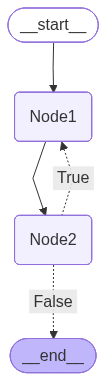

In [104]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [105]:
thread = {"configurable": {"thread_id": str(10)}}
graph.invoke({"count":0, "scratch":"hi"},thread)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [108]:
from pprint import pprint

pprint(graph.get_state(thread))

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b12-64a0-8004-cc4be9f0053a'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-22T15:01:48.629516+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0f-6bc4-8003-414103350bdc'}}, tasks=(), interrupts=())


In [ ]:
# look at the state history

for state in graph.get_state_history(thread):
    print(state, "\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b12-64a0-8004-cc4be9f0053a'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-22T15:01:48.629516+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0f-6bc4-8003-414103350bdc'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0f-6bc4-8003-414103350bdc'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-22T15:01:48.628469+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0e-6148-8002-261444c6e79b'}}, tasks=(PregelTask(id='bb50774d-807d-a11e-317f-49be7bd585fa', name='Node2', path=('__pregel_

In [110]:
states = []
for state in graph.get_state_history(thread):
    states.append(state.config)
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b12-64a0-8004-cc4be9f0053a'}} 4
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0f-6bc4-8003-414103350bdc'}} 3
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0e-6148-8002-261444c6e79b'}} 2
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0a-666a-8001-68aa036799db'}} 1
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b08-646e-8000-4b2a10ecdfe0'}} 0
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b07-60c8-bfff-5188b29e5fcf'}} 0


In [111]:
states[-3]

{'configurable': {'thread_id': '10',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0af580-8b0a-666a-8001-68aa036799db'}}

In [112]:
graph.get_state(states[-3])

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0a-666a-8001-68aa036799db'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-22T15:01:48.626276+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b08-646e-8000-4b2a10ecdfe0'}}, tasks=(PregelTask(id='48ade508-c1e9-1bbd-2c2d-6049defe7d60', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

### go back in time

In [113]:
graph.invoke(None, states[-3])

node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

In [114]:
thread = {"configurable": {"thread_id": str(10)}}
for state in graph.get_state_history(thread):
    print(state.config, state.values['count'])

{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1f-6974-8004-1fe53048fda9'}} 4
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1d-675a-8003-9e800d8345c4'}} 3
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1b-6aea-8002-8347c684d472'}} 2
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b12-64a0-8004-cc4be9f0053a'}} 4
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0f-6bc4-8003-414103350bdc'}} 3
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0e-6148-8002-261444c6e79b'}} 2
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b0a-666a-8001-68aa036799db'}} 1
{'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af580-8b08-646e-8000-4b2a10ecdfe0'}} 0
{'configurable': {'thread_id': '10', 'checkpoint_ns': ''

You can see the details below. Lots of text, but try to find the node that start the new branch. Notice the parent config is not the previous entry in the stack, but is the entry from state[-3].

In [115]:
thread = {"configurable": {"thread_id": str(10)}}
for state in graph.get_state_history(thread):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1f-6974-8004-1fe53048fda9'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-22T15:05:57.252334+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1d-675a-8003-9e800d8345c4'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 3}, next=('Node2',), config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1d-675a-8003-9e800d8345c4'}}, metadata={'source': 'loop', 'step': 3, 'parents': {}}, created_at='2025-10-22T15:05:57.251461+00:00', parent_config={'configurable': {'thread_id': '10', 'checkpoint_ns': '', 'checkpoint_id': '1f0af589-ce1b-6aea-8002-8347c684d472'}}, tasks=(PregelTask(id='cb4a1c29-f980-a948-70ce-b920e2564789', name='Node2', path=('__pregel_

## Modify State

In [116]:
thread2 = {"configurable": {"thread_id": str(11)}}
graph.invoke({"count":0, "scratch":"hi"},thread2)

node1, count:0
node2, count:1
node1, count:2
node2, count:3


{'lnode': 'node_2', 'scratch': 'hi', 'count': 4}

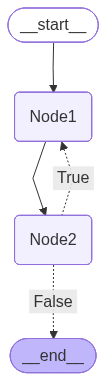

In [118]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [119]:
states2 = []
for state in graph.get_state_history(thread2):
    states2.append(state.config)
    print(state.config, state.values['count'])   

{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec42-6270-8004-cc6a09734bca'}} 4
{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec3f-6b38-8003-aa57aec6bde5'}} 3
{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec3b-6c2c-8002-cf397201f702'}} 2
{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec39-647c-8001-666758f30ca2'}} 1
{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec36-6916-8000-39edf32ab858'}} 0
{'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec35-657a-bfff-c47a399926dd'}} 0


In [120]:
save_state = graph.get_state(states2[-3])
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hi', 'count': 1}, next=('Node2',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec39-647c-8001-666758f30ca2'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-22T15:08:41.469856+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec36-6916-8000-39edf32ab858'}}, tasks=(PregelTask(id='a6b16972-5e7e-0f88-b32f-77c593f583cb', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now modify the values. One subtle item to note: Recall when agent state was defined, count used operator.add to indicate that values are added to the current value. Here, -3 will be added to the current count value rather than replace it.

In [121]:
save_state.values["count"] = -3
save_state.values["scratch"] = "hello"
save_state

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -3}, next=('Node2',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec39-647c-8001-666758f30ca2'}}, metadata={'source': 'loop', 'step': 1, 'parents': {}}, created_at='2025-10-22T15:08:41.469856+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec36-6916-8000-39edf32ab858'}}, tasks=(PregelTask(id='a6b16972-5e7e-0f88-b32f-77c593f583cb', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result={'lnode': 'node_2', 'count': 1}),), interrupts=())

Now update the state. This creates a new entry at the top, or latest entry in memory. This will become the current state.

In [122]:
graph.update_state(thread2,save_state.values)

{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0af597-e088-6012-8005-94b26ad4e6d8'}}

Current state is at the top. You can match the thread_ts. Notice the parent_config, thread_ts of the new node - it is the previous node.

In [123]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af597-e088-6012-8005-94b26ad4e6d8'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2025-10-22T15:12:14.992174+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec42-6270-8004-cc6a09734bca'}}, tasks=(PregelTask(id='85524d7a-60b5-0899-6117-79f1196236f2', name='Node1', path=('__pregel_pull', 'Node1'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hi', 'count': 4}, next=(), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af58f-ec42-6270-8004-cc6a09734bca'}}, metadata={'source': 'loop', 'step': 4, 'parents': {}}, created_at='2025-10-22T15:08:41.473491+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_n

### Try again with as_node

When writing using update_state(), you want to define to the graph logic which node should be assumed as the writer. What this does is allow the graph logic to find the node on the graph. After writing the values, the next() value is computed by travesing the graph using the new state. In this case, the state we have was written by Node1. The graph can then compute the next state as being Node2. Note that in some graphs, this may involve going through conditional edges! Let's try this out.

In [124]:
graph.update_state(thread2,save_state.values, as_node="Node1")

{'configurable': {'thread_id': '11',
  'checkpoint_ns': '',
  'checkpoint_id': '1f0af59c-9adb-6352-8006-cb95a498c748'}}

In [125]:
for i, state in enumerate(graph.get_state_history(thread2)):
    if i >= 3:  #print latest 3
        break
    print(state, '\n')

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': -2}, next=('Node2',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af59c-9adb-6352-8006-cb95a498c748'}}, metadata={'source': 'update', 'step': 6, 'parents': {}}, created_at='2025-10-22T15:14:21.903947+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af597-e088-6012-8005-94b26ad4e6d8'}}, tasks=(PregelTask(id='a4b972cd-f38b-9606-987d-ec994f081385', name='Node2', path=('__pregel_pull', 'Node2'), error=None, interrupts=(), state=None, result=None),), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 1}, next=('Node1',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af597-e088-6012-8005-94b26ad4e6d8'}}, metadata={'source': 'update', 'step': 5, 'parents': {}}, created_at='2025-10-22T15:12:14.992174+00:00', parent_config={'configurable': {'thread_id': '11',

`invoke` will run from the current state if not given a particular `thread_ts`. This is now the entry that was just added.

In [126]:
graph.invoke(None,thread2)

node2, count:-2
node1, count:-1
node2, count:0
node1, count:1
node2, count:2


{'lnode': 'node_2', 'scratch': 'hello', 'count': 3}

Print out the state history, notice the `scratch` value change on the latest entries.

In [127]:
for state in graph.get_state_history(thread2):
    print(state,"\n")

StateSnapshot(values={'lnode': 'node_2', 'scratch': 'hello', 'count': 3}, next=(), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af5a0-c024-6cb8-800b-cff4d90ec93c'}}, metadata={'source': 'loop', 'step': 11, 'parents': {}}, created_at='2025-10-22T15:16:13.188009+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af5a0-c022-6558-800a-05a5b068d75e'}}, tasks=(), interrupts=()) 

StateSnapshot(values={'lnode': 'node_1', 'scratch': 'hello', 'count': 2}, next=('Node2',), config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af5a0-c022-6558-800a-05a5b068d75e'}}, metadata={'source': 'loop', 'step': 10, 'parents': {}}, created_at='2025-10-22T15:16:13.186999+00:00', parent_config={'configurable': {'thread_id': '11', 'checkpoint_ns': '', 'checkpoint_id': '1f0af5a0-c020-6988-8009-1e93fa76523f'}}, tasks=(PregelTask(id='b556bb6c-ceb9-bfb2-905d-84f865a2cd6e', name='Node2', path=('_

In [128]:
conn.close()